## Create downsampled image from already downsampled masiv stack

Requirements:

MaSIV downsampled tif stack 

(for xy resolution of 0.8 or 1, it is better to have the masiv downsample factor multiples of 5 for calculating down sample ratio to avoid floats with many decimal places)

user inputs: original resolution, MaSIV downsample factor, goal resolution (10 or 25 um allen atlas), output directory


In [1]:
import os

import tkinter as tk
import tkinter.filedialog as fdialog
from tkinter import simpledialog
# this is the gui for finding directory and files

# from PIL import Image
#Image.MAX_IMAGE_PIXELS = 1000000000     
# this line is needed to load full res image because PIL sees images larger than 36mb as potential decompressed bomb for DOS attacks
# here we increase the upper limit of the image size from 89,478,485 (hard coded default value in pil) 

import skimage
from skimage import io
from skimage import transform as tf

import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Select the directory containing already stitched planes from stitchit (Rob code)
stack=fdialog.askopenfile(initialdir='Z:\\', title='select the MaSIVed stack to be further downsampled').name                               

# User input required for raw xyz resolution and goal dimension
xy = simpledialog.askfloat("Input", "What is the x and y resolution in um?",
                               minvalue=0.0, maxvalue=100)
z = simpledialog.askfloat("Input", "What is the z resolution in um?",
                               minvalue=0.0, maxvalue=100)
goal_xyz = simpledialog.askfloat("Input", "What do you want to downsample the resolution to '(in um)' ?",
                               minvalue=10, maxvalue=100)

outdir = fdialog.askdirectory(title='Please select the output directory')

In [3]:
masiv_ds=stack[stack.find('_DS')+len('_DS'):stack.rfind('.tif')]
masiv_ds=float(masiv_ds)
masiv_xy= round (xy*masiv_ds,2)
print (f'MASIV stack is downsampled : {masiv_ds}, The masiv stack is : {masiv_xy} um/pixels') 
# note that this gives a float and have many decimal places which the end digit is non-zero
# for avoiding confusion we keep the 2 decimal places

MASIV stack is downsampled : 6.0, The masiv stack is : 6.0 um/pixels


In [4]:
masiv_xy=5

In [4]:
# displays origional resolution, goal, and calculated ratio for downsampling
ratioxy= round (goal_xyz/masiv_xy, 3)
ratioz=goal_xyz/z

message = (f"Sample resolution is {xy, xy, z} um in x y z. "
f"downsampling to {goal_xyz} um. "
f"dowmsample ratio is xy = {ratioxy} and z = {ratioz}.")

message


'Sample resolution is (1.0, 1.0, 10.0) um in x y z. downsampling to 25.0 um. dowmsample ratio is xy = 4.167 and z = 2.5.'

### Downsampling

Load entire tiff stack
First read and resample the xy planes using skimage, loop through each z
Then store all the the downsampled xy in a numpy array
finally resample z (ie, do xz or yz, downsample for 1 and 5 times)

note that here we use the NearestNeighbor for resizing (defined by the **order** parameter in skimage.transform.resize)

<u>0: Nearest-neighbor</u> 1: Bi-linear (default) 2: Bi-quadratic 3: Bi-cubic 4: Bi-quartic 5: Bi-quintic

(Helpful info on what these do: https://dsp.stackexchange.com/questions/707/what-are-the-practically-relevant-differences-between-various-image-resampling-m

and https://en.wikipedia.org/wiki/Image_scaling)

__IMPORTANTA__: from 0 to 5 there is an increase in smoothness which is what we want/not want.

When downsampling images that we want our <u> signal to popout</u>  , we want the **nearest neighbor**,and also to turn the **antialiasing off** (a gaussian filter to increase smoothness)

When downsampling single cell data , we just want a <u>nice smooth image</u>  for better registration. Use **bilinear** and turn **antialiasing on**

skimage.transform.downscale_local_mean only allows downsamples by an integer factor

In [6]:
#Old code for reading directly into single xy planes from stitched image 100, replaced by reading downsampled stack from masiv to save time

# os.chdir(tempdir)
# image_path = [os.path.abspath(x) for x in os.listdir(tempdir)]
# print(image_path[0])

# # pre-define original image size and downsampled image size since all images have the same xy
# im = image.open(image_path[0], mode='r')
# w, h = im.size
# new_imagesize= [round(w/ratioxy), round(h/ratioxy)]

In [5]:
im = io.imread(stack)
#reads the entire image stack into memory (huge, takes about 5min to read a 25gb stack)

z,y,x= im.shape
print (im.shape) 
#shape is now z, y (rows), x(columns)

new_rows=int(y/ratioxy)
new_col=int(x/ratioxy)
new_z=int(z/ratioz)
tifarray = np.zeros([new_rows, new_col, z])

print( f'new shape of the data is  x y z= {new_rows, new_col, new_z}')

(855, 1751, 2386)
new shape of the data is  x y z= (420, 572, 342)


In [6]:
#downsampling in xy, again takes long . Almost hitting the memory
for i in range (z):
    new_xyplane=tf.resize(im[i,:,:],[new_rows, new_col], order=1, anti_aliasing=1)
    tifarray[:,:,i]= new_xyplane

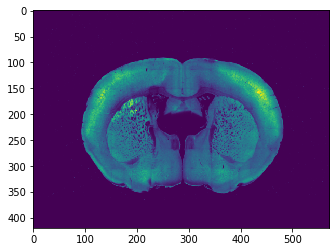

In [7]:
# test to see if things worked
plt.imshow(tifarray[:,:,336])

In [10]:
# plt.imshow(np.roll(tifarray[:,:,135], -65, axis=0))

In [11]:
# # Specific to AL077 where imaging field of view is shifted upward by 26pixels (25um resolution), or 65 (10um resolution) between slice 136 and 137  (135 and 136 in python index)


# for numbers in range(136):
#     temp= tifarray[:,:,numbers]
#     aligned= np.roll(temp, -65, axis=0)
#     tifarray[:,:,numbers]=aligned
# # plt.imshow(np.roll(aligned, -26, axis=0))

# #FOR AL077 ONLY

In [8]:
del im
# to save memory, especially for downsampling to 10um voxels

In [9]:
#down sampling in z using yz plane (can use xz plane also). This time is very fast
tifarray2 = np.zeros([new_rows, new_col, new_z])

if ratioz==1:
    print('z axis is not downsampled')
    tifarray2=tifarray
else:
    tifarray2 = np.zeros([new_rows, new_col, new_z])
    for i in range (new_rows):
        new_xyplane=tf.resize(tifarray[i,:,:], [new_col, new_z], order=0, anti_aliasing=0)
        tifarray2[i,:,:,]= new_xyplane

In [10]:
del tifarray
#save memory

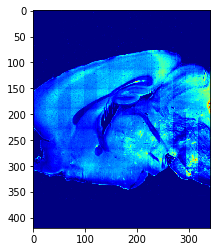

In [11]:
# test to see if things worked. This should show saggital section if masiv stack is coronal
plt.jet()
plt.imshow(tifarray2[:,300,:])

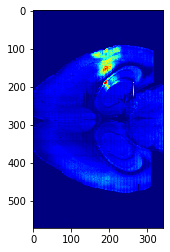

In [12]:
# test to see if things worked. This should show horizontal section if masiv stack is coronal
plt.imshow(tifarray2[150,:,:])

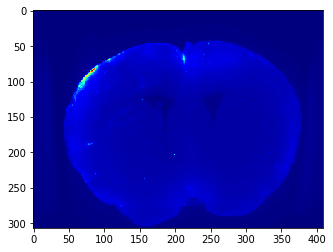

In [17]:
#### This cell is to change horizontal images to coronal planes, usually for images acquired with mesospim and COLM !!
tifarray_transpose = np.swapaxes(tifarray2, 0,2)
plt.imshow(tifarray_transpose[:,:,150])

In [13]:
#elastix do not work when taking 32bit as moving image some how in my hand.. stick with 16bit



imguint16=skimage.img_as_uint(tifarray2)
# need to convert float64 (tifarray2) to uint before saving as mhd
#This line is for input image that is coronal

#imguint16=skimage.img_as_uint(tifarray_transpose)
#this line is for input image that is not coronal


C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [19]:
# # saving the downsampled output
# io.imsave('AL08025um.mhd', stuff[:,:,300], plugin= 'simpleitk')
# #this only works on saving 2d images...

In [15]:
coronal_planetmp= np.swapaxes(imguint16,0,2)
#for some reason, if just save stuff as tiff, it will save y planes of xz view although the origonal matrix is arranged as y x z
#here we shift the 3rd dimension with the first dimension to obtain xy view

coronal_plane= np.swapaxes(coronal_planetmp,1,2)
#saving stuff2 gave coronal image but rotated 90degrees anticlockwise
#rotate the col(1) with row(2) now to get normal coronal view


In [16]:
out_name= outdir[3:8]+f'_{goal_xyz}um.tiff'
out_name

'VE103_25.0um.tiff'

In [17]:
os.chdir(outdir)
io.imsave(out_name, coronal_plane)

### currently need to manually save this as .mhd file in imageJ
Which is ok for now, since need to open in imageJ anyways to crop the template and atlas

To do, find out how to use simpleitk for 3d mhd file